In [18]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [19]:
faces = loadmat('data.mat')['face']
faces = faces.transpose([2,0,1]).reshape(600, 24, 21)

In [20]:
neutral_faces = faces[0::3,:,:]
exp_faces = faces[1::3,:,:]
illum_faces = faces[2::3,:,:]

neutral_faces.shape

(200, 24, 21)

In [21]:
X = np.concatenate([neutral_faces, exp_faces], axis=0)
X.shape

(400, 24, 21)

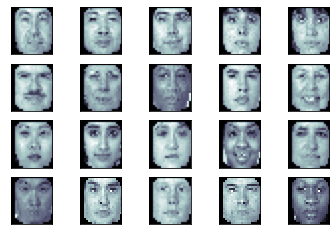

In [22]:
fig, ax = plt.subplots(4,5)

for i, axis in enumerate(ax.flat):
    axis.imshow(X[i, :, :], cmap='bone')
    axis.set(xticks=[], yticks=[])

In [23]:
# zeros are for neutral faces and ones are for smiling faces
y = np.concatenate([np.zeros(200), np.ones(200)])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=42,
    test_size=0.2,
    shuffle=True
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]) 

In [25]:
pca = PCA(n_components=15, whiten=False, random_state=42)
pca.fit(X_train)

X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

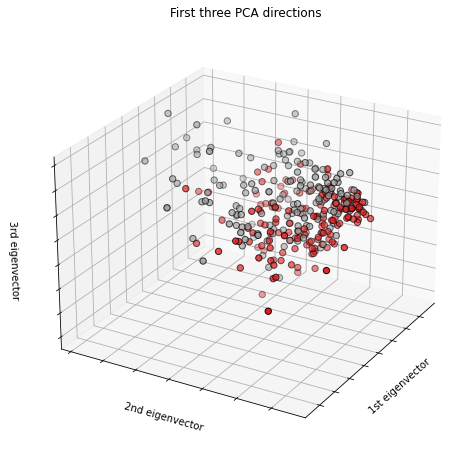

In [26]:
def PCA_viz(X, y):# this plot is used to show how the data is transformed after reducing it to 3d. Using 3 components results in worse accuracy.
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-155, azim=150)
    X_reduced = PCA(n_components=3).fit_transform(X)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])
    plt.show()
    
PCA_viz(X_train, y_train)    

In [27]:
nb = GaussianNB()
nb.fit(X_train_reduced, y_train)
nb_test_accuracy = nb.score(X_test_reduced, y_test)
nb_pred = nb.predict(X_test_reduced)

nb_test_accuracy

0.925

In [28]:
nb_confusion_matrix = confusion_matrix(y_test, nb_pred)

# confusion matrix in form of a pandas dataframe
nb_cm = pd.DataFrame(data=nb_confusion_matrix, columns=[['predicted','predicted'], ['neutral', 'smiling']],
                    index=[['actual','actual'], ['neutral','smiling']])
nb_cm

predicted        
                 neutral smiling
actual neutral        41       3
       smiling         3      33

In [29]:
knn_accuracies = []
for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_train_reduced, y_train)
    knn_accuracies.append({
        f"neighbors_{i}": knn.score(X_test_reduced, y_test)
    })

In [30]:
def count(accuracy, total_samples):
    return {
        "accuracy": accuracy,
        "correct": int(np.ceil(total_samples * accuracy)),
        "misclassified": int(np.ceil(total_samples * (1 - accuracy)))
    }

In [31]:
def plot_accuracies(accuracies):
    plt.plot(
        range(1, len(accuracies) + 1),
        [acc[f'neighbors_{i+1}'] for i, acc in enumerate(accuracies)],
    )
    plt.xlabel('neighbors')
    plt.ylabel('accuracy')
    plt.show()

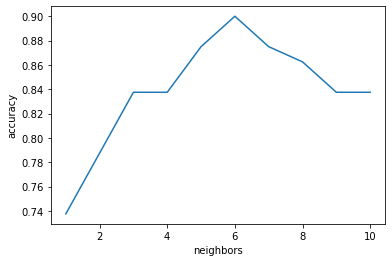

In [32]:
plot_accuracies(knn_accuracies)

In [33]:
percent_accuracies = [acc[f'neighbors_{i+1}'] for i, acc in enumerate(knn_accuracies)]
classfication_count = [count(acc, X_test.shape[0]) for acc in percent_accuracies]
classfication_count

[{'accuracy': 0.7375, 'correct': 59, 'misclassified': 21},
 {'accuracy': 0.7875, 'correct': 63, 'misclassified': 17},
 {'accuracy': 0.8375, 'correct': 67, 'misclassified': 13},
 {'accuracy': 0.8375, 'correct': 67, 'misclassified': 13},
 {'accuracy': 0.875, 'correct': 70, 'misclassified': 10},
 {'accuracy': 0.9, 'correct': 72, 'misclassified': 8},
 {'accuracy': 0.875, 'correct': 70, 'misclassified': 10},
 {'accuracy': 0.8625, 'correct': 69, 'misclassified': 11},
 {'accuracy': 0.8375, 'correct': 67, 'misclassified': 13},
 {'accuracy': 0.8375, 'correct': 67, 'misclassified': 13}]

### Test sample size

The accuracy on the test set was optimal when the test size was ```0.2``` of the total ```400``` images. Reducing or increasing the test size achieved worse results. 

```random_state = 42``` variable was set with ```PCA``` and ```train_test_split``` to make sure all the experiments were reproducible.

### KNearestNeighbors

After playing with value of PCA components, the best value found was 15. Below that achieved worse accuracies as most information from the features was lost. Thus, the accuracies were not as best.

### GaussianNB 

The Naive Bayes' classfier ```GaussianNB``` fits on the data better than Nearest Neighbors Classifier and achieves an accuracy of ```0.925```, which is better than the best accuracy achieved my the nearest neighbors classifier.